
Lambda School Data Science

*Unit 2, Sprint 4, Build Week*

---

## In order to successfully meet the criteria for Build Week, your project must demonstrate that you have done the following:

* Chosen an appropriate dataset (see below).
* Chosen the target from your dataset that your model will predict.
* Specified whether that target requires a regression or a classification model.
* Chosen appropriate performance metrics to evaluate your model.
* Split your dataset into training, test, and (if applicable) validation sets.
* Established a baseline performance score for your dataset.
* Built and trained a linear model for your dataset.
* Built and trained a tree-based model for your dataset.
* Evaluated your models’ performance on the test set in comparison to your baseline.
* Commited your commented code to a GitHub repo.
* Published a blog post reporting on your project that
    * is 300 words long,
    * explains how you chose your dataset and what steps you took to wrangle it,
    * explains which performance metrics you chose and why,
    * details how your models performed on the test set,
    * contains two visualizations learned in Unit 2, accompanied by explanations of what those visualizations show about your model(s).

## Stretch Goals

* Used hyperparameter tuning to improve the performance of your linear model.
* Used hyperparameter tuning to improve the performance of your tree-based model.
* Deployed an interactive web app that uses one of your models. 

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

# I. Wrangle Data

In [40]:
DATA_PATH ='data/esrb/'

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score, recall_score, classification_report

In [42]:
def wrangle(fm_path):
    df = pd.read_csv(DATA_PATH + fm_path,
                    index_col='title')
    # Col strong_language misspell
    df = df.rename(columns={'strong_janguage': 'strong_language'})
    return df
pd.set_option('display.max_columns', None)

In [43]:
df = wrangle('Video_games_esrb_rating.csv')
df_test = wrangle('test_esrb.csv')

# II. Data Exploration

In [44]:
df.head()

,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,language,lyrics,mature_humor,mild_blood,mild_cartoon_violence,mild_fantasy_violence,mild_language,mild_lyrics,mild_suggestive_themes,mild_violence,no_descriptors,nudity,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_language,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,E
Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ET
NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,M
Jamestown+,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ET
Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,T


In [45]:
df.shape

(1895, 33)

In [46]:
df.isna().sum().sum()

0

Data is clean with no missing value

# III. Split Data

In [47]:
target = 'esrb_rating'
# Split data for train data set
X = df.drop(columns=target)
y = df[target]
# Split data for test data set
X_test = df_test.drop(columns=target)
y_test = df_test[target]

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Establish Baseline

In [49]:
baseline = y_train.value_counts(normalize=True).max()
baseline

0.358179419525066

In [50]:
esrb_rating_percent = pd.DataFrame(y_train.value_counts(normalize=True))

In [51]:
# import plotly.express as px
# fig = px.pie(esrb_rating_percent, values='esrb_rating', names=esrb_rating_percent.index, title='ESRB Ratings')
# fig.update_traces(textposition='inside', textinfo='percent+label')
# fig.show()

# IV. Build Model

## Random Forest

In [52]:
model_rf = RandomForestClassifier(random_state=42,
                                n_jobs=-2)
model_rf.fit(X_train, y_train);

## SKGB Classifier

In [53]:
model_skgb = GradientBoostingClassifier(random_state=42)
model_skgb.fit(X_train, y_train);

## XGBoost Classifier

In [57]:
model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train, y_train);

[10:51:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# V. Check Metrics

In [58]:
print('RF Training accuracy', model_rf.score(X_train, y_train))
print('RF Validation accuracy', model_rf.score(X_val, y_val))
print('SKGB Training Accuracy:', model_skgb.score(X_train, y_train))
print('SKGB Validation Accuracy:', model_skgb.score(X_val, y_val))
print('XGB Training Accuracy:', model_xgb.score(X_train, y_train))
print('XGB Validation Accuracy:', model_xgb.score(X_val, y_val))

RF Training accuracy 0.924802110817942
RF Validation accuracy 0.8522427440633246
SKGB Training Accuracy: 0.887203166226913
SKGB Validation Accuracy: 0.8443271767810027
XGB Training Accuracy: 0.9228232189973615
XGB Validation Accuracy: 0.862796833773087


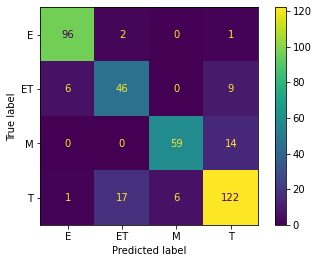

In [59]:
plot_confusion_matrix(model_rf, X_val, y_val)
plt.show()

In [60]:
report_rf = classification_report(y_val, model_rf.predict(X_val))
print(report_rf)

              precision    recall  f1-score   support

           E       0.93      0.97      0.95        99
          ET       0.71      0.75      0.73        61
           M       0.91      0.81      0.86        73
           T       0.84      0.84      0.84       146

    accuracy                           0.85       379
   macro avg       0.85      0.84      0.84       379
weighted avg       0.85      0.85      0.85       379



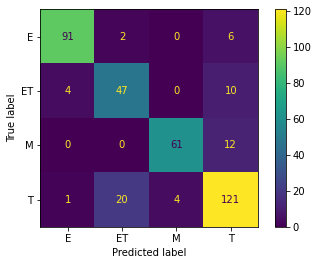

In [61]:
plot_confusion_matrix(model_skgb, X_val, y_val)
plt.show()

In [62]:
report_skgb = classification_report(y_val, model_skgb.predict(X_val))
print(report_skgb)

              precision    recall  f1-score   support

           E       0.95      0.92      0.93        99
          ET       0.68      0.77      0.72        61
           M       0.94      0.84      0.88        73
           T       0.81      0.83      0.82       146

    accuracy                           0.84       379
   macro avg       0.84      0.84      0.84       379
weighted avg       0.85      0.84      0.85       379



In [63]:
report_xgb = classification_report(y_val, model_xgb.predict(X_val))
print(report_xgb)

              precision    recall  f1-score   support

           E       0.94      0.97      0.96        99
          ET       0.73      0.75      0.74        61
           M       0.92      0.84      0.88        73
           T       0.84      0.85      0.84       146

    accuracy                           0.86       379
   macro avg       0.86      0.85      0.85       379
weighted avg       0.86      0.86      0.86       379



# VI. Tune Model

In [69]:
params = {
    'n_estimators': [350, 400, 450, 500],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1],
    'n_jobs': [-2],
    'random_state': [42]
}

model = GridSearchCV(
    estimator=model_xgb, 
    param_grid=params,
    cv=10,
    n_jobs=-2
)
model.fit(X, y);

[11:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [70]:
best_score = model.best_score_
best_params = model.best_params_

print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)

Best score for `model`: 0.8649651907546645
Best params for `model`: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'n_jobs': -2, 'random_state': 42}


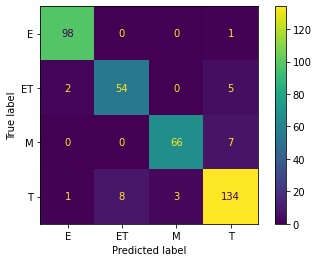

In [71]:
plot_confusion_matrix(model, X_val, y_val)
plt.show()

In [72]:
report = classification_report(y_val, model.predict(X_val))
print(report)

              precision    recall  f1-score   support

           E       0.97      0.99      0.98        99
          ET       0.87      0.89      0.88        61
           M       0.96      0.90      0.93        73
           T       0.91      0.92      0.91       146

    accuracy                           0.93       379
   macro avg       0.93      0.92      0.93       379
weighted avg       0.93      0.93      0.93       379



In [73]:
perm_imp = permutation_importance(
    model,
    X_val, 
    y_val,
    n_repeats=5,
    n_jobs=-2,
    random_state=42
)

In [74]:
data = {'imp_mean': perm_imp['importances_mean'],
      'imp_std': perm_imp['importances_std']}
# Create a permutation dataframe which contain permutation mean and std
permu_table = pd.DataFrame(data, index=X_val.columns).sort_values(by='imp_mean')

In [75]:
permu_table

,imp_mean,imp_std
nudity,0.000528,0.001974
use_of_drugs_and_alcohol,0.000528,0.001055
partial_nudity,0.002111,0.001974
mature_humor,0.003166,0.001055
console,0.003694,0.006376
mild_language,0.003694,0.001293
mild_cartoon_violence,0.004222,0.001293
use_of_alcohol,0.006860,0.003579
sexual_content,0.007388,0.001055
mild_fantasy_violence,0.010026,0.004222


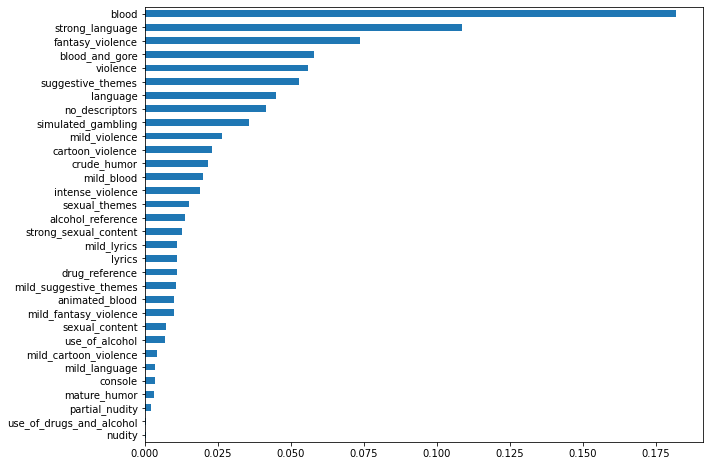

In [76]:
plt.figure(figsize=(10,8))
permu_table['imp_mean'].plot(kind='barh');

## Compare test set

In [77]:
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

           E       0.95      0.95      0.95       100
          ET       0.86      0.83      0.84       126
           M       0.88      0.59      0.71        90
           T       0.74      0.89      0.81       184

    accuracy                           0.83       500
   macro avg       0.86      0.81      0.83       500
weighted avg       0.84      0.83      0.83       500



## Train model again using top 5 features

In [128]:

# Get feature list name for the top 5 most important features
feature_list = permu_table[-10:].index.tolist()
X_train_feature_filtered = X_train[feature_list]
X_val_feature_filtered = X_val[feature_list]
X_test_feature_filtered = X_test[feature_list]
# Build a pipeline/ model
pipeline_filtered = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=400, random_state=42)

# Fit on train, score on val
pipeline_filtered.fit(X_train_feature_filtered, y_train)
print('Validation Accuracy', pipeline_filtered.score(X_val_feature_filtered, y_val))

[11:36:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation Accuracy 0.7915567282321899


In [129]:
feature_list

['mild_violence',
 'simulated_gambling',
 'no_descriptors',
 'language',
 'suggestive_themes',
 'violence',
 'blood_and_gore',
 'fantasy_violence',
 'strong_language',
 'blood']

## Save your model in .joblib

In [130]:
from joblib import dump
dump(pipeline_filtered, 'pipeline.joblib', compress=True)

['pipeline.joblib']

# VII. Communication

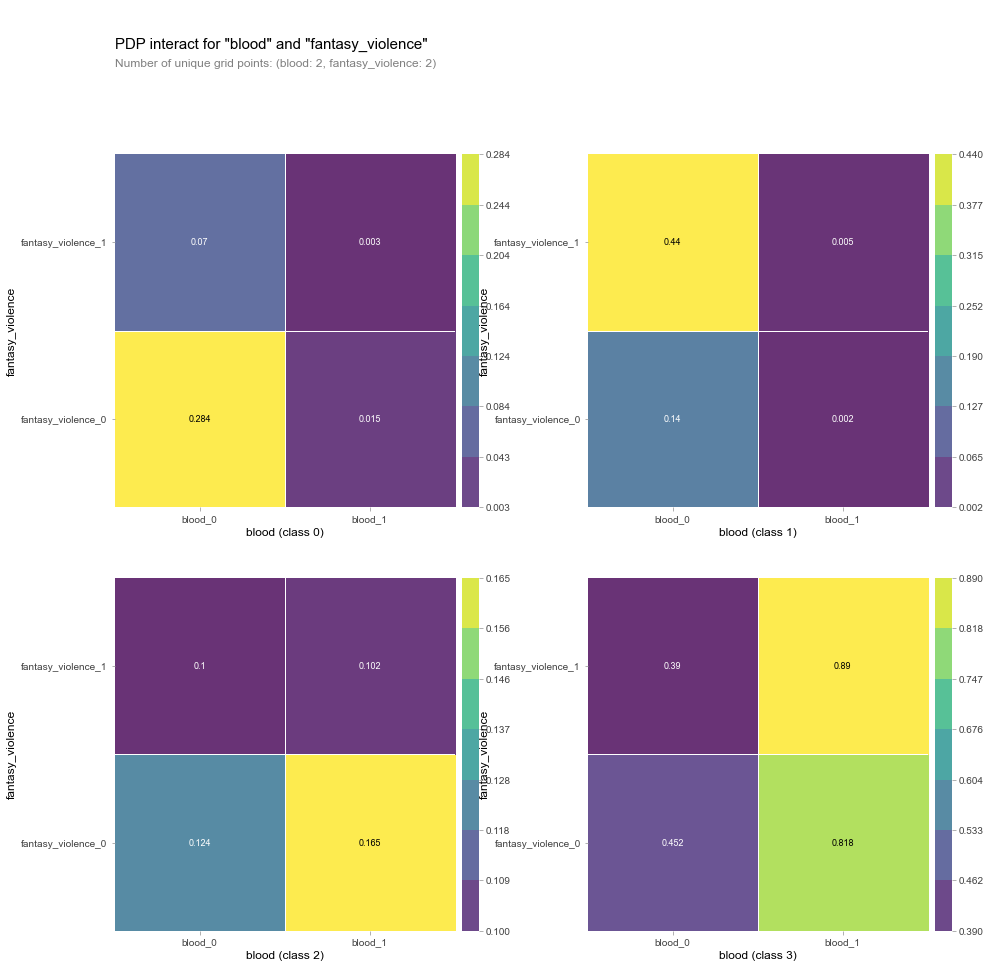

In [131]:
features = ['blood', 'fantasy_violence']

interact = pdp_interact(
    model,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

In [126]:
X_train_feature_filtered.iloc[0,:]

mild_violence         0
simulated_gambling    0
no_descriptors        0
language              0
suggestive_themes     0
violence              0
blood_and_gore        0
fantasy_violence      1
strong_language       0
blood                 0
Name: GALAK-Z: The Void, dtype: int64

In [141]:
model_shap = XGBClassifier(max_depth=4, n_estimators=450)
model_shap.fit(X, y)
shap.initjs()
explainer = shap.TreeExplainer(pipeline_filtered)
shap_values = explainer.shap_values(X_train_feature_filtered)

# visualize the first prediction's explanation
# shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][1])
shap.force_plot(explainer.expected_value[0], shap_values[0][1], X_test_feature_filtered.iloc[0])

[11:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


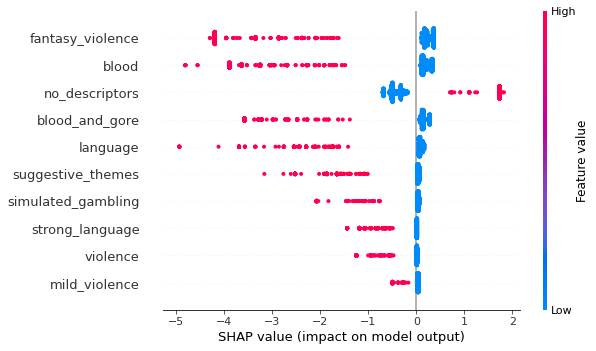

In [139]:
shap.summary_plot(shap_values[0], X_train_feature_filtered)